# Necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import random
import cv2
import os
import splitfolders
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras import applications
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tifffile import imsave
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()

# Dataloader

In [3]:
def load_img(img_dir, images_list):
    images=[]
    for i, image_name in enumerate(images_list):    
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, images_list, mask_dir, mask_list, batch_size):

    L = len(images_list)
  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, images_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


training_data_path_images = "train/images/"
training_data_path_masks = "train/masks/"
training_images_list=os.listdir(training_data_path_images)
training_masks_list = os.listdir(training_data_path_masks)

batch_size = 512

training_images_datagenerator = imageLoader(training_data_path_images, training_images_list, 
                                training_data_path_masks, training_masks_list, batch_size)



Text(0.5, 1.0, 't2')

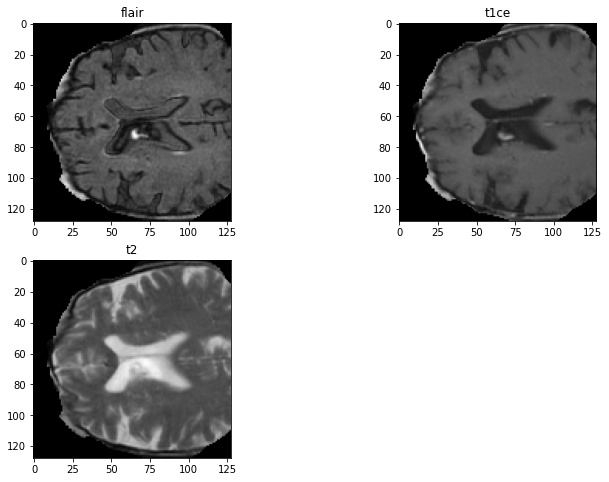

In [6]:
img, msk = training_images_datagenerator.__next__()


num = random.randint(0,img.shape[0]-1)
test_img=img[num]

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(test_img[:,:, 0], cmap='gray')
plt.title('flair')
plt.subplot(222)
plt.imshow(test_img[:,:, 1], cmap='gray')
plt.title('t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:, 2], cmap='gray')
plt.title('t2')

# Customized inception net model for brain tumor segmentation

In [12]:
kernel_initializer =  'he_uniform'
model = applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model1 = Sequential()
model1.add(Model(model.input, model.output))
model1.add(Conv2DTranspose(1024, (2, 2), strides=(2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv2DTranspose(512, (2, 2), strides=(2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv2DTranspose(256, (2, 2), strides=(2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv2DTranspose(64, (2, 2), strides=(2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv2DTranspose(16, (2, 2), strides=(2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv2DTranspose(4, (2, 2), strides=(2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv2D(4, (1, 1), activation='softmax'))

In [13]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2, 2, 2048)        21802784  
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 4, 4, 1024)       8389632   
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 8, 8, 512)        2097664   
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 16, 16, 256)      524544    
 ranspose)                                                       
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 32, 32, 64)       65600     
 ranspose)                                            

# Transfer Learning

In [9]:
#Freezing weights for all layers other than custom layers
for layer in model1.layers[:-7]:
    layer.trainable = False

In [14]:
#training
#images and masks are 128x128x3
training_data_path_images = "train/images/"
training_data_path_masks = "train/masks/"

images_list = os.listdir(training_data_path_images)
masks_list = os.listdir(training_data_path_masks)

image_count = len(os.listdir(training_data_path_images))

#Define the image generators for training and validation

training_data_path_images = "train/images/"
training_data_path_masks = "train/masks/"

validation_data_path_images = "val2/images/"
validation_data_path_masks = "val2/masks/"
 
training_images_list=os.listdir(training_data_path_images)
training_masks_list = os.listdir(training_data_path_masks)

validation_images_list=os.listdir(validation_data_path_images)
validation_masks_list = os.listdir(validation_data_path_masks)

#training
batch_size = 512
training_images_datagenerator = imageLoader(training_data_path_images, training_images_list, 
                                training_data_path_masks, training_masks_list, batch_size)

validation_images_datagenerator = imageLoader(validation_data_path_images, validation_images_list, 
                                validation_data_path_masks, validation_masks_list, batch_size)

In [15]:
import segmentation_models_3D as sm
import tensorflow as tf
dice_l = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) #dice loss
focal_l = sm.losses.CategoricalFocalLoss()

#focal loss
total_l = dice_l + (1 * focal_l) #total loss
cce = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
LR = 0.0001
model_optimizer = Adam(LR)


#Fitting the model
steps_per_epoch = len(training_images_list)//batch_size
val_steps_per_epoch = len(validation_images_list)//batch_size


model = model1

model.compile(optimizer = model_optimizer, loss=cce, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(training_images_datagenerator,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=validation_images_datagenerator,
          validation_steps=val_steps_per_epoch,
          )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2, 2, 2048)        21802784  
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 4, 4, 1024)       8389632   
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 8, 8, 512)        2097664   
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 16, 16, 256)      524544    
 ranspose)                                                       
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 32, 32, 64)       65600     
 ranspose)                                            

In [11]:
model.save('brats_2d_inceptionnet.hdf5')

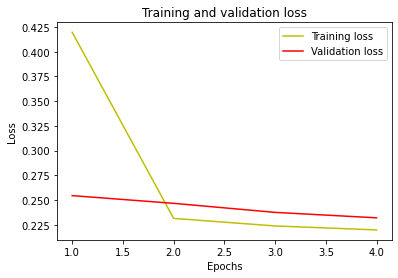

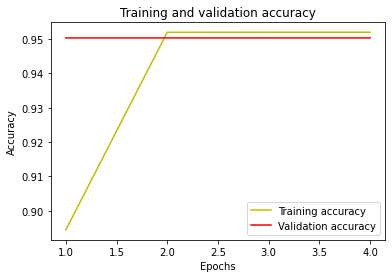

In [7]:
#plotting training and val IoU and loss for each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Post processing

In [ ]:
#Adding IOU Score
os.chdir('/home/dsnikhil/DL Project 3')
my_model = load_model('brats_2d_inceptionnet.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_l,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [ ]:
random_image = np.random.randint(1,259)
input_image = []
input_mask = []
pred_mask = []
os.chdir('/home/dsnikhil/DL Project 3/train/images')
for i in range(128):
    input_image.append(np.load('MRI_{}_image_{}.npy'.format(random_image,i)))
os.chdir('/home/dsnikhil/DL Project 3/train/masks')
for i in range(128):
    input_mask.append(np.load('MRI_{}_mask_{}.npy'.format(random_image,i)))

In [ ]:
for i in range(128):
    test_img = input_image[i]
    test_img_input = np.expand_dims(test_img, axis=0)
    test_prediction = my_model.predict(test_img_input)
    test_prediction = test_prediction.squeeze()
    pred_mask.append(test_prediction)
input_image = np.array(input_image)
input_mask = np.array(input_mask)
pred_mask = np.array(pred_mask)
input_mask = np.moveaxis(input_mask,0,2)
pred_mask = np.moveaxis(pred_mask,0,2)

In [ ]:
or_seg_mask = np.argmax(input_mask,axis=3)
plt.imshow(or_seg_mask[:,:,43])
plt.title('Original Segmentation Mask')
plt.show()
pred_seg_mask = np.argmax(pred_mask,axis=3)
plt.imshow(pred_seg_mask[:,:,43])
plt.title('Prediction Segmentation Mask')
plt.show()